# CRM Analytics (RFM Analysis, CLTV)

1- **Data Understanding** (Veriyi anlama)

2- **Data Preperation** (Veri ön işleme)

3- **Creating RFM Segments** (RFM Analizi ile müşterilerin Recency ve Frequency değerlerini kullanarak müşteri segmentasyonu gerçekleştireceğiz.)

4- **Calculated CLTV** (Bir müşterinin şirket için değerinin hesaplanıp segmentlere ayrılmasını göreceğiz.)

5- **Predicted CLTV** (Bu müşteri değeri hesaplamasının zaman eksenli bir projeksiyonu olmadığı için zaman projeksiyonu getirerek geleceğe yönelik müşteri değeri hesaplamayı ve segmentlere ayırmayı gerçekleştireceğiz.)
 * BG-NBD modeli ile gelceğe yönelik beklenen satışların tahmini,
 * Gamma-Gamma modeli ile geleceğe yönelik beklenen karlılık tahmini gerçekleştireceğiz.
 * BG-NBD ve Gamma-Gamma modelleri ile belirli bir zaman periyodu için CLTV tahmini gerçekleştireceğiz.

6- Tüm çalışmaları tek bir çatı altında toplayarak proje üzerinden önemli yorumlamalar yapacağız.

---

### Veri Seti Hikayesi  👉  https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Online Retail II, İngiltere merkezli bir e-ticaret şirketinin 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içermektedir. Şirket hediyelik eşya satışı gerçekleştirmekte ve müşterileri de toptancılardır.

### Veri Setindeki Değişkenler

* **Invoice:** Fatura numarası. Her faturaya ait eşsiz numara. Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder.
* **StockCode:** Ürün kodu. Her bir ürün için eşsiz numara.
* **Description:** Ürün ismi
* **Quantity:** Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
* **InvoiceDate:** Fatura tarihi ve zamanı.
* **UnitPrice:** Ürün fiyatı
* **CustomerID:** Eşsiz müşteri numarası
* **Country:** Ülke ismi. Müşterinin yaşadığı ülke.


# 1- Data Understanding

In [1]:
# Projede gerekli olan kütüphanelerin import işlemini yapıyoruz.
import datetime as dt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

# Çıktıda tüm sütun ve satırları gözlemlemek için;
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Çıktıda sütunların alta kaymasını engellemek için sütunları yan yana getireceğimiz kod.
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Veri Setini okuma işlemlerini gerçekleştiriyoruz. Projede 2010-2011 yılına ait verileri kullanacağız.
df_ = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [3]:
# Veri setini boyutu fazla olduğundan dolayı veriyi okutma süresi uzun sürmektedir. 
# Herhangi bir sebeple veriyi tekrar okutmamız gerekirse beklememek için veriyi kopyalıyoruz. 
df = df_.copy()

### Veri okuma işlemini gerçekleştirdik.
### Veriyi anlamaya çalışacağız.

In [4]:
# Veri setindeki ilk 5 gözlem değerini inceliyoruz.
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Veride kaç satır, kaç sütun vardır?
df.shape

(541910, 8)

In [6]:
# Kaç eşsiz ürün var? 
df["Description"].nunique()

4223

In [7]:
# Hangi üründen kaçar tane var?
df["Description"].value_counts().head()   

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

In [8]:
# En çok sipariş edilen ilk 5 ürün hangileridir? 
# Veri setindeki ürün isimlerini(Description) groupby alarak ürün adetlerinin(Quantity) toplamını alıyoruz.
# Ürün adetine(Quantity) göre büyükten küçüğe sıralıyoruz. .head() işlemiyle ilk 5 gözleme bakıyoruz.
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
JUMBO BAG RED RETROSPOT,47363
ASSORTED COLOUR BIRD ORNAMENT,36381
POPCORN HOLDER,36334
PACK OF 72 RETROSPOT CAKE CASES,36039


In [9]:
# En pahalı ilk 5 ürün hangileridir?
# Veri setindeki ürün isimlerini(Description) groupby alarak ürün fiyatlarının(Price) maksimum değerini alıyoruz.
# Ürün fiyatına(Price) göre büyükten küçüğe sıralıyoruz. .head() işlemiyle ilk 5 gözleme bakıyoruz.
df.groupby("Description").agg({"Price":"max"}).sort_values("Price", ascending = False).head()

,Price
Description,
Manual,38970.00
AMAZON FEE,17836.46
Adjust bad debt,11062.06
POSTAGE,8142.75
DOTCOM POSTAGE,4505.17


In [10]:
# En çok ürün satın alan müşteriler hangi ülkeden satın alma gerçekleştirmiştir?
df.groupby("Country").agg({"Quantity":"sum"}).sort_values("Quantity", ascending=False).head()

,Quantity
Country,
United Kingdom,4263829
Netherlands,200128
EIRE,142637
Germany,117448
France,110481


# 2- Data Preperation

In [11]:
# İlk olarak eksik gözlemimiz var mı onu kontrol edelim.
# Kod, değişkenlerdeki toplam eksik gözlem sayısını vermektedir.
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [12]:
# Eksik gözlemler üzerinde de işlemler yapabilirim ancak veri setimde çok fazla gözlem var. 
# Bu proje özelinde eksik gözlemleri veri setinden direk siliyorum.
# axis=0 satıra göre, axis=1 sütuna göre işlem yapar. İnplace=True ise bu işlemi atama yapmadan kalıcı hale getirir.
df.dropna(axis=0, inplace=True)
# İsnull fonskiyonu ile tekrar eksik gözlem kontrolü yapıyorum. Görüldüğü üzere eksik gözlemleri temizledik.
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [13]:
# Fatura numaraları(Invoice) değişkeninde "C" ile başlayan değerler iade olan faturaları ifade ediyordu.
# Biz bu çalışmada iade olan faturalarla ilgili bir analiz yapmayacağımız için,
# Invoice değişkeninde C içeren gözlemlerin dışındakileri seçerek tekrar df olarak atama yapıyoruz.
df = df[~df["Invoice"].str.contains("C", na=False)]

In [14]:
# Bu işlemlerden sonra satır ve sütun sayılarımıza bakalım.
df.shape

(397925, 8)

In [15]:
# Bu bölümde veri setinin betimsel istatistiklerine bakmak önemlidir.
# Eğer bir aykırılık göze çarparsa bu aykırlığı gidermek için işlemler yapmamız gerekir.
# Aşağıda ürün adeti(Quantity) ve ürün fiyatınının(Price) istatistiklerini incelediğimizde ;
# İki değişkenin de %99'luk ve maksimum değerleri arasında ciddi bir aykırılık görülmektedir.
df.describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,397925.0,13.021793,180.419984,1.0,1.00,1.00,2.00,6.00,12.00,36.0,120.00,80995.00
Price,397925.0,3.116212,22.096773,0.0,0.42,0.55,1.25,1.95,4.15,8.5,14.95,8142.75
Customer ID,397925.0,15294.308601,1713.172738,12346.0,12627.00,12883.00,13969.00,15159.00,17101.00,17912.0,18211.00,18287.00


In [16]:
# Analize gözlem aykırlığını gidererek devam etmemiz gerekiyor.
# Aşağıdaki outlier_thresholds fonksiyonu ile aykırı değerler için bir eşik değer belirliyoruz.
# Alt ve Üst sınır olarak bir eşik değer belirliyoruz. Bu aykırı gözlemler eşik değerin dışında kalıyor.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [17]:
# replace_with_thresholds fonksiyonunda ise aykırı olan değerleri outlier_thresholds fonksiyonunda saptaığımız eşik değerlerle değiştiriyoruz.
# Yani aykırı değerler artık bizim belirlediğimiz çeyreklikte eşik değerlerle değişmiş oluyor.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [18]:
# Artık hem ürün adeti(Quantity) değişkeninde hem de ürün fiyatı(Price) değişkenindeki aykırlığı giderebiliriz. 
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [19]:
df.describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,397925.0,11.833709,25.534486,1.0,1.00,1.00,2.00,6.00,12.00,36.0,120.00,298.50
Price,397925.0,2.893201,3.227143,0.0,0.42,0.55,1.25,1.95,4.15,8.5,14.95,37.06
Customer ID,397925.0,15294.308601,1713.172738,12346.0,12627.00,12883.00,13969.00,15159.00,17101.00,17912.0,18211.00,18287.00


In [20]:
# Quantity ve Price değişkenleri ürün adet ve her bir ürünün birim fiyatını göstermektedir.
# Biz çalışmamızda toplam fatura fiyatını değerlendireceğiz.
# Bunun için ise "Quantity" ve "Price" değişkenlerindeki gözlemleri çarparak yeni bir "Total Price" değişkeni oluşturacağız.
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [21]:
# Tüm veri ön işleme adımlarından sonra artık verimizin son halinden ilk 5 gözlemi görebiliriz.
# Total Price değişkeni de görülmektedir.
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# 3- Creating RFM Segments

RFM, müşterilerin satın alma alışkanlıkları üzerinden onları segmentlere ayırarak pazarlama ve satış stratejileri belirlemeye yardımcı olur.

3 davranış metriğinin baş harflerinden meydana gelir.

* **Recency :** Müşterinin şirketle son temasından yani müşterinin son satın almasından bugüne kadar geçen süredir.
    * (Recency = Bugünün tarihi - Son satın alma tarihi)
    * Burada dikkat etmemiz gereken nokta Recency değeri olacaktır. Bu değerde Frequency ve Monetary metriklerine göre tersten bir skorlama yapılmaktadır.
    * Recency değeri yani müşterinin en son satın alma gerçekleştirdiği tarih ne kadar yakınsa bizim için bir o kadar değerlidir. Bu yüzden yukarıdaki Recency formülünden gelecek olan sonuç ne kadar küçük olursa bizim için skorlamada o kadar yüksek puan alacaktır.

* **Frequency :** Müşterinin toplam satın alma sayısını gösterir.

* **Monetary :** Müşterinin alışverişlerinde yaptığı toplam harcamadır.

Frequency ve Monetray metriklerinin ise değerleri ne kadar yüksekse skorlamada da o kadar yüksek puan alacaktır.

In [22]:
# Veri setindeki değişkenler ile Receny, Frequency ve Monetary skorlarını oluşturacağız.
df. info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397925 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397925 non-null  object        
 1   StockCode    397925 non-null  object        
 2   Description  397925 non-null  object        
 3   Quantity     397925 non-null  float64       
 4   InvoiceDate  397925 non-null  datetime64[ns]
 5   Price        397925 non-null  float64       
 6   Customer ID  397925 non-null  float64       
 7   Country      397925 non-null  object        
 8   TotalPrice   397925 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 30.4+ MB


### Recency Metriğinin Hesaplanması

Recency için referans bir tarih belirleyip müşterilerin son satın alma tarihlerini bu referans tarihten çıkaracağız.

(Recency = Bugünün tarihi - Son satın alma tarihi)

Bunu nasıl yapacağız?
 * Öncelikle bir referans tarih belirleyeceğiz. Bunun sebebi ise recency formülündeki bugünün tarihini belirlemek. Bugünün tarihi dediğimiz durum aslında müşterinin en son kaç gün önce satın alma gerçekleştirdiğini bulmak istiyoruz. Bunun için de bugünün tarihini veri setinin maksimum gününden 1-2 gün sonrası olarak belirleyip bu tarihten her bir müşteri özelinde son satın alma tarihini çıkardığımızda Recency değerimize ulaşabiliriz.
 * 1-2 gün sonrasını belirlememizdeki mantık ise veri setinin en son gününde satın alma gerçekleştiren müşterilerimizin Recency formülündeki çıkarma işleminden dolayı recency değerlerinin "0" gelmesini engellemek.
 * Recency, müşterinin son satın almasını temsil ettiği için fatura tarihi(InvoiceDate) değişkeni kullanacağız. 
 * Müşteriler("CustomerID") bazında groupby alarak lambda fonksiyonu InvoiceDate değişkenini gezerek belirlediğimiz referans tarihi her bir müşterinin son satın alma tarihinden çıkaracağız.
 * `dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days `
 
### Frequency Metriğinin Hesaplanması

Frequency, müşterinin toplam satın alma sayısını ifade ettiği için fatura değişkenini(Invoice) kullanacağız.

 * Müşteriler("CustomerID") bazında groupby alarak lambda fonksiyonu (Invoice) değişkenini  gezerek her fatura numarasının eşsiz değerini bize saydıracak. Müşterinin kaç farklı satın alma gerçekleştirdiğini göreceğiz.
 * `dataframe.groupby('Customer ID').agg({'Invoice': lambda num: num.nunique()})`
 
### Monetary Metriğinin Hesaplanması 

Monetary, müşterinin alışverişlerinde yaptığı toplam harcamayı ifade ettiği için 20. satırda "Ouantity" ve "Price" değişkenlerinin çarpımlarıyla oluşturduğumuz "TotalPrice" değişkenini kullanacağız.

 * Müşteriler("CustomerID") bazında groupby alarak lambda fonksiyonu (TotalPrice) değişkenini gezerek ilgili müşteriye ait her toplam satın alma tutarını toplamını bize verecektir. Müşterinin yapmış olduğu toplam harcamayı göreceğiz.
 * `dataframe.groupby('Customer ID').agg({"TotalPrice": lambda price: price.sum()})`

In [23]:
# Veri setindeki maksimum tarihi görelim. Ona göre referans bir tarih belirleyeceğiz.
# Maksimum tarihimiz 09.12.2011
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [24]:
# Referans tarih belirleyeceğiz. Maksimum tarihten 2 gün sonrasını seçiyorum.
today_date = dt.datetime(2011, 12, 11)

In [25]:
# Artık Recency, Frequency ve Monetary değerlerinden oluşacak RFM Tablomuzu oluşturabiliriz.
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalPrice": lambda price: price.sum()})

In [26]:
# RFM Tablosunun ilk 5 gözlemini görüyoruz.
# Bu tablo 'InvoiceDate', 'Invoice' ve 'TotalPrice' değişkenlerinden oluşuyor.
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,326,1,310.44
12347.0,3,7,4310.00
12348.0,76,4,1770.78
12349.0,19,1,1491.72
12350.0,311,1,331.46


In [27]:
# Yukarıdaki değişkenlerimiz bizim artık Recency, Frequency ve Monetary değerlerimizi ifade ediyor.
# O zaman değişkenlerin isimlerini değiştirebiliriz.rfm.columns'a yeni isimleri atıyorum.
rfm.columns = ['recency', 'frequency', "monetary"]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,326,1,310.44
12347.0,3,7,4310.00
12348.0,76,4,1770.78
12349.0,19,1,1491.72
12350.0,311,1,331.46


In [28]:
# Oluşturduğumuz rfm tablomuzda monetray ve frequency değerlerimizde "0"'dan büyük olmayanlar var mı diye kontrol amaçlı bir bakıyoruz.
# Bu kontrolü yapmamın sebebi ise Frequency ve Monetray değerleri "0" gelmemesi lazım.
# Kontrol sonucunda Müşteri 1 satın alma gerçekleştirmiş ancak müşterinin bıraktığı toplam tutar "0" birim.
# Böyle bir durum gerçekleşmesi mümkün olmayacağı için bunu iki değişken için de 0 dan büyük olanları tekrar rfm olarak atama yapıyoruz.
rfm[~((rfm["monetary"]) > 0 & (rfm["frequency"] > 0))]

,recency,frequency,monetary
Customer ID,,,
13256.0,15,1,0.0


In [29]:
rfm = rfm[(rfm['monetary'] > 0)]

In [30]:
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,326,1,310.44
12347.0,3,7,4310.00
12348.0,76,4,1770.78
12349.0,19,1,1491.72
12350.0,311,1,331.46


Artık RFM metriklerini hesaplamış bulunmaktayız. Tekrardan hatırlamak için;
 * Recency : Müşterilerimizin son satın alma tarihinden referans tarihe kadar geçen süreyi ifade ediyor.
 * Frequency : Müşterilerimizin toplam satın alma sayılarını ifade ediyor.
 * Monetary : Müşterilerin bu satın almalar sonucunda toplam harcama tutarını ifade ediyor.

Gelin birlikte örnek olarak yukarıdan bir müşteriyi yorumlayalım.
 * 12348 ID'lı müşterimiz, 76 gün önce alışveriş yapmış. 4 satın alma gerçekleştirmiş. Bu satın almalar sonucunda bıraktığı toplam tutar 1770.78 birimdir. 
 
Artık RFM skorlarını hesaplamaya geçebiliriz.

### RFM Skorlarının Hesaplanması

RFM metriklerini daha kolay karşılaştırabilmek açısından 1–5 arasında değerler vererek metrikleri RFM skorlarına çevireceğiz. Bununla beraber 1 çok kötü, 5 çok iyi olacak şekilde müşterileri segmentlere ayırmış olucağız.

Buradaki önemli nokta ise biz müşterilerimizin segmentlerini tanımlarken sadece Recency ve Frequency değerlerini kullanacağız. Çünkü Monetary değeri RFM segmenti tanımlamada kullanılmıyor. Rfm segmenti tanımlamada önemli olan değişkenler müşterimizin en son satın alma yaptığı tarih ve yapmış olduğu satın alma sayısı bunları da bize sırasıyla Recency ve Frequency değişkenleri veriyor.

Peki RFM skorlarını nasıl oluşturacağız ?

* .qcut() fonksiyonu ile değişkeni küçükten büyüğe sıralayıp istediğimiz çeyreklik değere bölmüş oluyoruz.

* Recency değişkenini küçükten büyüğe sıralarken En küçük olana 5 puan verip, en yüksek olana 1 puan vereceğiz.Çünkü en küçük olan sayı en yakın satın alma yapmış olanları ifade ettiğinden dolayı en iyi skoru en küçük sayıya veriyoruz.
    * `pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])`

* Frequency değişkeninde ise satın alma sayısı en fazla olana 5, en az satın alma sayısına sahip olana 1 skorlarını vereceğiz.
    * `pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])`

In [31]:
# Yukarıda ifade ettiğimiz şekilde RFM skorlarını hesaplıyoruz.
# recency_score ve frequency_score olarak atama yapıyoruz.
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

Artık RFM Metrikleri ve RFM Skorlarını oluşturduk.

Örneğin aşağıdaki tabloyu yorumladığımızda;
* 12347 ID'li müşteri recency değeri 3, Frequecny değeri 7, yani müşteri en son 3 gün önce alışveriş yapmış ve bu benim için önemli bir metrik olduğundan dolayı RFM skoru olarak 5 puanı aldı. Aynı müşterinin satın alma sayısı da 7 olduğu için yine frequecny skoru olarak 5 puanını aldı.

In [32]:
# Artık RFM Metrikleri ve RFM Skorlarını oluşturduk.
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score
Customer ID,,,,,
12346.0,326,1,310.44,1,1
12347.0,3,7,4310.00,5,5
12348.0,76,4,1770.78,2,4
12349.0,19,1,1491.72,4,1
12350.0,311,1,331.46,1,1


### RFM Segmentlerinin Oluşturulması

RFM skorlarını oluşturduktan sonra aşağıdaki yaygın olarak kullanılan RFM tablosuna göre RFM segmentlerini oluşturacağız. Aşağıdaki tabloda müşteriler segmentlere ayrılmıştır. Bu tabloda Frequecy ve Recency olarak 2 metrik bulunmaktadır. Skorlarımızı biz de bu 2 metrik üzerinden oluşturmuştuk. 2 Metrik için de 1 çok iyi, 5 çok kötü anlamına gelir.

Biz de müşterilerimizi yukarıdaki onların davranışlarından oluşturduğumuz skorlara göre Frequency ve Recency değerleri ile aşağıdaki tablo özelinde segmentlere ayıracağız.

Gelin önce beraber tablodan birkaç sınıfı inceleyelim;
 * Champions sınıfında yer alanlar bizim için en değerli müşterilerdir. Bu sınıfın son satın alma tarihi en erken ve satın alma sayısı en fazla olan sınıftır.
 * Loyal Customer sınıfında yer alanlar bizim sadık müşterilerimizdir. Bu sınıfta bulunanların Recency değeri 3 ve 4, Frequency değeri ise 4 ve 5 skorlarından oluşur.
 * At Risk sınıfında bulunanlar ise riskli sınıfı temsil eder. Bu sınıfta bulunanların Recency değeri 1 ve 2, Frequecny değeri ise 3 ve 4 skorlarından oluşur. Yani En son satın alma tarihi üzerinden uzun bir süre geçmiş ve bu uzun süre önce satın alma sayıları ortalama olan müşterilerdir.
 
Tabloyu bu şekilde yorumlayabiliriz.

![](https://miro.medium.com/max/805/1*TjJt4rUiBtXLAF84--V-Cg.png)

Biz artık RFM skorlarımızı oluşturduk. Şimdi ise bu skorları kullanarak müşterilerimizi yukarıda gördüğümüz tablo özelinde segmentlere ayıracağız. Örneğin Frequency değeri 5 ve Recency değeri 5 olan müşterimize "Champions" sınıfında yer vereceğiz.

In [33]:
# Önce bir segment değişkeni atayalım. Toplamlarını yukarıdaki tabloyu oluştururken kullanacağız.
# Tipi str yapmamın sebebi ise matematiksel olarak toplama işlemi yapmayacağız. Sadece rakamları yan yana getireceğiz.
# Aşağıda tabloda rfm_segment değişkeninde yaptığımız işlem görülmektedir.
rfm['rfm_segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,rfm_segment
Customer ID,,,,,,
12346.0,326,1,310.44,1,1,11
12347.0,3,7,4310.00,5,5,55
12348.0,76,4,1770.78,2,4,24
12349.0,19,1,1491.72,4,1,41
12350.0,311,1,331.46,1,1,11


In [34]:
# Bu tablo bile bize birşeyler anlatmaktadır. 
# Örneğin satın alma davranışı en iyi müşterilerimizi görelim.
rfm[rfm["rfm_segment"] == "55"].head()

,recency,frequency,monetary,recency_score,frequency_score,rfm_segment
Customer ID,,,,,,
12347.0,3,7,4310.00,5,5,55
12362.0,4,10,5226.23,5,5,55
12417.0,4,9,3649.10,5,5,55
12423.0,1,8,1859.31,5,5,55
12433.0,1,7,13375.87,5,5,55


In [35]:
# Satın alma davranışı en kötü müşterilerimizi görelim.
rfm[rfm["rfm_segment"] == "11"].head()

,recency,frequency,monetary,recency_score,frequency_score,rfm_segment
Customer ID,,,,,,
12346.0,326,1,310.44,1,1,11
12350.0,311,1,331.46,1,1,11
12353.0,205,1,89.00,1,1,11
12354.0,233,1,1079.40,1,1,11
12355.0,215,1,459.40,1,1,11


In [36]:
# Şimdi ise aşağıdaki Regular Expressions(Regex) yapısıyla müşterilerimizi RFM skorlarına göre yukarıda incelediğimiz renkli tablodaki RFM segmentlerine atayacağız.
# Müşterilerimizin Recency ve Frequency skorlarına göre hangi segmentte yer alacağını aşağıda tek tek belirtiyoruz.
# Örneğin Recency değeri 1-2, Frequency değeri ise 3 veya 4 olan müşteriler At_risk segmentine atanacaktır.
seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

In [37]:
# Bu Regex yapısını, RFM tablomuzdaki rfm_segment isimli değişkenle değiştirip dataframe'e çevirme işlemi yapıyoruz.
# rfm_segment değişkenimizde müşterilerimizin hangi sınıfta/segmentte olduğunu görebiliyoruz.
rfm['rfm_segment'] = rfm['rfm_segment'].replace(seg_map, regex=True)

In [38]:
rfm = rfm[["recency", "frequency", "monetary", "rfm_segment"]]
rfm.head()

,recency,frequency,monetary,rfm_segment
Customer ID,,,,
12346.0,326,1,310.44,hibernating
12347.0,3,7,4310.00,champions
12348.0,76,4,1770.78,at_risk
12349.0,19,1,1491.72,promising
12350.0,311,1,331.46,hibernating


In [39]:
# Segmentlerde kaçar müşterimiz var?
# Segmentlerin betimsel istatistiklerini inceleyelim.
rfm[["rfm_segment", "recency", "frequency", "monetary"]].groupby("rfm_segment").agg(["mean","median", "count"])

recency               frequency                  monetary                
                           mean median count       mean median count         mean    median count
rfm_segment                                                                                      
about_to_sleep        53.312500     53   352   1.161932      1   352   469.058097   325.355   352
at_risk              153.785835    139   593   2.878583      3   593   938.458341   668.360   593
cant_loose           132.968254    108    63   8.380952      7    63  2646.822540  2157.730    63
champions              6.361769      5   633  12.417062      8   633  6498.641414  2586.670   633
hibernating          217.605042    219  1071   1.101774      1  1071   398.573036   282.600  1071
loyal_customers       33.608059     30   819   6.479853      5   819  2752.519574  1717.360   819
need_attention        52.427807     52   187   2.326203      2   187   847.657086   638.050   187
new_customers          7.428571      8    42   1.000000      1    42   314.883690   274.505    42
potential_loyalists   17.398760     18   484   2.010331      2   484   674.628357   521.275   484
promising             23.510638     23    94   1.000000      1    94   285.623723   213.195    94

In [40]:
# Bu satırdaki işlemleri görselleştrime yapabilmek için uyguladım.
# Bu satırdaki işlemler projemiz ile ilgili bir kod içermemektedir.
rfm1 = rfm[["rfm_segment", "recency", "frequency", "monetary"]].groupby("rfm_segment").agg(["mean","median", "count"])
rfm1.columns = rfm1.columns.droplevel(0)
rfm1.reset_index(inplace=True)
rfm1.columns = ["rfm_segment","boş","boş","count","boş","boş","boş","boş","boş","boş"]
rfm1 = rfm1.sort_values(by="count", ascending=False)

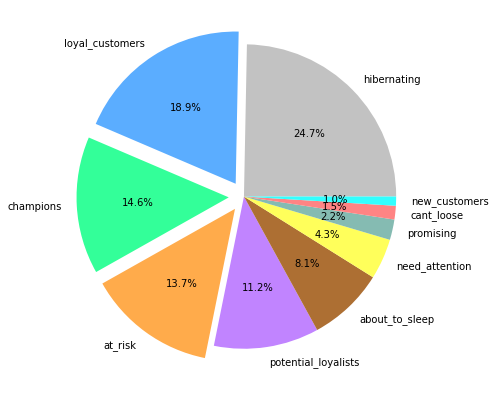

In [41]:
# Matplotlib kütüphanesini import ederek bir pie chart oluşturdum.
# Aşağıdaki görselde müşterilerimizin segmentlere göre dağılımını görüyoruz. 

import matplotlib.pyplot as plt

colors = ['#C2C2C2', '#5BADFF', '#33FF99', '#FFAB4B', 
          '#C184FF', '#AD6F33','#FFFF5B','#85BBB2',
          '#FF8484','#33FFFF']

fig1, ax1 = plt.subplots(figsize=(10,7))

ax1.pie(rfm1["count"] ,labels=rfm1["rfm_segment"].unique() ,colors=colors, 
        explode=[0,0.1,0.1,0.1,0,0,0,0,0,0] ,autopct='%1.1f%%');

### RFM Analizi Sonucu Yorumlama ve Aksiyon Kararları

RFM Segmentasyonu oluşturarak RFM analizi sürecini tamamladık.Yukarıdaki görsellerden faydalanarak betimsel istatistik tablolarını daha detaylı bir şekilde analiz ettim. RFM Analizi sonucunda yukarıdaki görselde pasta dilimi olarak ayırdığım 3 farklı segmenti seçerek bu sınıflar genelinde yorumlamalar ve bu sınıfta bulunan müşterilerimizle ilgili alınması gereken aksiyon planlarını bir sunum halinde hazırladım.

Seçtiğim sınıflarla ilgili bu sınıfları seçmemin önemi, sınıflardaki müşterilerin davranışlarıyla ilgili yorumlarım ve bu müşterilerle ilgili planladığım aksiyon kararlarına bu linkten ulaşabilirsiniz.

👉 [RFM_Segmentation](https://github.com/emreoksz/myprojects/blob/main/CRM%20(Customer%20Relationship%20Management)/Comments%20and%20Action%20Decisions/RFM_Segmentation.pdf)

---

# 4- Calculated CLTV

Şirketimizdeki tüm müşterilerden elde edilen toplam kazanç, toplam sipariş sayısı, toplam müşteri sayısı gibi durumları tüm müşteriler özelinde kıyaslayarak her bir müşterinin şirketimizdeki değerini hesaplayacağız. Sonrasında müşterilerimizi bu yaşam değerine göre segmentlere ayıracağız.

Müşteri değerini hesaplamak için bazı metriklere ihtiyacımız var. Bu metrikler ;

![](https://cdn-images-1.medium.com/max/800/1*qOR8X-PBdKHXXgLIqjc-SA.png)

![](https://cdn-images-1.medium.com/max/800/1*YzP7_bHcQYl6Hss8wp7aoA.png)

Tüm bu adımları gerçekleştirerek müşterimizin bizim şirketimizdeki değerini hesaplayacağız. Bu değere göre onları tekrar segmentlere atayacağız.

In [42]:
# Oluşturduğumuz RFM tablosu üzerinden ilk önce avg_order _value değerini hesaplayacağız.
# Müşterinin her işlemde ortalama ne kadar bıraktığını buluyoruz.
rfm['avg_order_value'] = rfm['monetary'] / rfm['frequency']

In [43]:
# purchase_frequency değerini hesaplıyoruz. Bu işlemle genele göre standartlaştırma yapıyoruz.
# Toplam sipariş sayısı / toplam müşteri sayısı
rfm["purchase_frequency"] = rfm['frequency'] / rfm.shape[0]

In [44]:
# Profit_margin
# Müşterinin toplam harcama tutarından %0.5 kar ettiğimizi varsayıyoruz.
rfm['profit_margin'] = rfm['monetary'] * 0.05

In [45]:
# Repeat_rate ve churn_rate
# Veri setinde en az 1 kere alışveriş yapan müşteri sayısı / tüm müşteri sayısı
repeat_rate = rfm[rfm.frequency > 1].shape[0] / rfm.shape[0]
churn_rate = 1 - repeat_rate

In [46]:
# Customer Value
rfm['cv'] = (rfm['avg_order_value'] * rfm["purchase_frequency"])

In [47]:
# Customer Lifetime Value
rfm['cltv'] = (rfm['cv'] / churn_rate) * rfm['profit_margin']

In [48]:
# Müşteri yaşam boyu değerini artık hesapladık.
rfm.head()

,recency,frequency,monetary,rfm_segment,avg_order_value,purchase_frequency,profit_margin,cv,cltv
Customer ID,,,,,,,,,
12346.0,326,1,310.44,hibernating,310.440000,0.000231,15.522,0.071563,3.227495
12347.0,3,7,4310.00,champions,615.714286,0.001614,215.500,0.993545,622.106497
12348.0,76,4,1770.78,at_risk,442.695000,0.000922,88.539,0.408202,105.012117
12349.0,19,1,1491.72,promising,1491.720000,0.000231,74.586,0.343873,74.522055
12350.0,311,1,331.46,hibernating,331.460000,0.000231,16.573,0.076408,3.679361


In [49]:
# MinMaxScaler
# Bulduğumuz CLTV değerini daha kolay okumak adına 1-100 arası puanlıyoruz.
# cltv_c adında yeni bir değişkene atıyoruz.Calculate edilmiş cltv değerine erişiyoruz.
scaler = MinMaxScaler(feature_range=(1, 100))
scaler.fit(rfm[["cltv"]])
rfm["cltv_c"] = scaler.transform(rfm[["cltv"]])

In [50]:
# Artık bu hesaplanmış müşteri yaşam değeri üzerinden de müşterilerim arasında bir segment oluşturabilirim.
#.qcut() fonksiyonu ile büyükten küçüğe sıralayıp en düşük segment C, en iyi müşterilerin bulunduğu segment A olacak şekilde grupluyoruz.
rfm["cltv_c_segment"] = pd.qcut(rfm["cltv_c"], 3, labels=["C", "B", "A"])

In [51]:
# İlk oluşturduğum RFM tablosu ile beraber hesaplanan cltv değeri ve bu değere göre oluşturduğum segmenti tek bir dataframe'de topluyorum. 
rfm_cltv = rfm[["recency", "frequency", "monetary", "rfm_segment","cltv_c", "cltv_c_segment"]]

In [52]:
# Hesapladığımız müşteri yaşam boyu değerine göre müşterilerimizi segmentlere ayırdık.
rfm_cltv.sort_values(by="cltv_c", ascending=False).head()

,recency,frequency,monetary,rfm_segment,cltv_c,cltv_c_segment
Customer ID,,,,,,
14646.0,2,74,266163.525,champions,100.000000,A
18102.0,1,60,231584.345,champions,75.947390,A
14911.0,2,201,139033.730,champions,28.013351,A
17450.0,9,46,131710.645,champions,25.242638,A
12415.0,25,21,120210.355,loyal_customers,21.193978,A


---

# 5- Predicted CLTV

Tüm müşterilerimizin kullanıcı davranışlarını göz önünde bulundurarak belli bir zaman projeksiyonu ile geleceğe yönelik Customer Life Time Value tahmini yapacağız.

Müşteriye ait elimizde ortalama en son ne zaman satın alma yaptığı, bıraktığı gelir ve satın alma frekansı olsa da ileriye dönük tahmin yapamıyor olmamızın sebebi,
 * Şirket açısından tüm müşterilerin davranış dağılımı elimizde yok.
 * Bireyler açısından da bu olasılık dağılımına göre bir tahmin yok.

BG-NBD ve Gamma-Gamma modelleri ile bu sorunu çözerek ileriye dönük tahminleme yapmış olacağız.

CLTV tahmini gerçekleştirirken RFM tablosuna benzer bir tablo oluşturup, ek olarak Tenure değeri ekleyeceğiz. **Tenure**, müşterinin şirket ile ilk kontağından referans belirlediğimiz tarihe kadar geçen zaman olarak tanımlanır. Belirlediğimiz referans tarihten müşterinin ilk satın alma yaptığı tarih çıkarılarak hesaplanabilir. Buna ek olarak Recency değeri hesaplarken referans tarihimizden son satın alma tarihini çıkarıyorduk. Ancak CLTV tahmini yaparken müşterinin satın alma yaptığı son tarihten, satın alma yaptığı ilk tarihi çıkarmamız gerekiyor. Bunun sebebi ise; BGNBD ve Gamma-Gamma modelleri formülleri bizden argümanları bu hesaplama mantığıyla istiyor. 

 * **recency_cltv_p :** `lambda date: (date.max() - date.min()).days`
 * **Tenure :** `lambda date: (today_date - date.min()).days`
 

In [53]:
#Referans seçtğimiz tarihi hatırlayarak başlayalım.
today_date

datetime.datetime(2011, 12, 11, 0, 0)

In [54]:
# RFM tablosuna benzer tablomuzu oluşturuyoruz.
rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                                lambda date: (today_date - date.min()).days],
                                                'Invoice': lambda num: num.nunique(),
                                                'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [55]:
#Hiyerarşik index yapısı oluştuğundan dolayı onu ortadan kaldırıyoruz.
rfm.columns = rfm.columns.droplevel(0)

In [56]:
rfm.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0,0,326,1,310.44
12347.0,365,368,7,4310.00
12348.0,282,359,4,1770.78
12349.0,0,19,1,1491.72
12350.0,0,311,1,331.46


In [57]:
# Değişkenler lambda olarak geldiği için sütunları tekrar isimlendiriyoruz. 
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']

In [58]:
# Gamma gamma modeli klasik monetry değerini değil de ortalama monetray değerini ister.
# Her bir işlemde(Frequency) müşteri ortalama ne kadar bırakmış.
# Her bir müşteri Her bir faturada ortalama ne kadar kazandırmış.
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

In [59]:
# monetary değeri Gamma-Gamma modeline uygun hale geldi.
rfm.head()

,recency_cltv_p,T,frequency,monetary
Customer ID,,,,
12346.0,0,326,1,310.440000
12347.0,365,368,7,615.714286
12348.0,282,359,4,442.695000
12349.0,0,19,1,1491.720000
12350.0,0,311,1,331.460000


In [60]:
# Gamma-Gamma modeli için yapmış olduğumuz değişikliğin farkedilmesi açısından monetary değerini de monetary_avg olarak değiştiriyoruz. 
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

In [61]:
# BGNB Modeli için haftalık Recency (recency_weekly_p) ve haftalık Tenure (T_weekly) değerlerini hesaplıyoruz.
# Bu değerler kaç hafta önce alışveriş yaptığı ve kaç haftalık müşteri oldupu bilgisini veriyor.
rfm["recency_weekly_cltv_p"] = rfm["recency_cltv_p"] / 7  # kaç hafta önce alışveriş yaptığı
rfm["T_weekly"] = rfm["T"] / 7  # kaç haftalık müşteri olduğu

In [62]:
# Kontrol için monetary_avg değerlerinin "0" dan büyük olanları alıyoruz.
rfm = rfm[rfm["monetary_avg"] > 0]

In [63]:
# Daha sağlıklı bir CLTV hesabı için; 
rfm = rfm[(rfm['frequency'] > 1)]

In [64]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly
Customer ID,,,,,,
12347.0,365,368,7,615.714286,52.142857,52.571429
12348.0,282,359,4,442.695000,40.285714,51.285714
12352.0,260,297,8,219.542500,37.142857,42.428571
12356.0,302,326,3,937.143333,43.142857,46.571429
12358.0,149,151,2,575.210000,21.285714,21.571429


In [65]:
# BG-NBD ve Gamma-Gamma modelleri frequency değerini float istemiyor.
# O yüzden kontrol amaçlı yine de frequency tipini int yapıyoruz.
rfm["frequency"] = rfm["frequency"].astype(int)

In [66]:
# BGNBD modelinin fit edilmesi, BG-NBD modelinin fit edilmesi ile beklenen satış adetlerinin tahmini adımına geçebiliriz. 
bgf = BetaGeoFitter(penalizer_coef=0.01)
    
bgf.fit(rfm['frequency'],
        rfm['recency_weekly_cltv_p'],
        rfm['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.06, alpha: 9.30, b: 1.13, r: 1.78>

In [67]:
# 1 aylık beklenen satışların tahminini veren kod.
# recency_weekly_cltv_p ve T_weekly değerini haftalık değere çevirdiğimiz için modelde 4 yazmamız bize 1 aylık beklenen satışları verir.
rfm["exp_sales_1_month"] = bgf.predict(4,
                                        rfm['frequency'],
                                        rfm['recency_weekly_cltv_p'],
                                        rfm['T_weekly'])

In [68]:
# 3 aylık beklenen satışların tahminini veren kod.
rfm["exp_sales_3_month"] = bgf.predict(12,
                                        rfm['frequency'],
                                        rfm['recency_weekly_cltv_p'],
                                        rfm['T_weekly'])

In [73]:
# Müşterilerin geleceğe yönelik 1 ve 3 aylık periyotta beklenen satışlarını tabloda görüyoruz.
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month
Customer ID,,,,,,,,
12347.0,365,368,7,615.714286,52.142857,52.571429,0.561684,1.678069
12348.0,282,359,4,442.695000,40.285714,51.285714,0.364322,1.087951
12352.0,260,297,8,219.542500,37.142857,42.428571,0.739160,2.206857
12356.0,302,326,3,937.143333,43.142857,46.571429,0.333040,0.993934
12358.0,149,151,2,575.210000,21.285714,21.571429,0.474048,1.408955


In [74]:
# Gamma-Gamma modelinin fit edilmesi, Gamma-Gamma modelinin fit edilmesi ile beklenen karlılık tahmini adımına geçebiliriz. 
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(rfm['frequency'], rfm['monetary_avg'])

rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

In [75]:
# Tabloda görünen expacted_average_profit ile müşterilerin beklenen karlılığının tahmin etmiş olduk. 
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month,expected_average_profit
Customer ID,,,,,,,,,
12347.0,365,368,7,615.714286,52.142857,52.571429,0.561684,1.678069,631.911974
12348.0,282,359,4,442.695000,40.285714,51.285714,0.364322,1.087951,463.745539
12352.0,260,297,8,219.542500,37.142857,42.428571,0.739160,2.206857,224.886669
12356.0,302,326,3,937.143333,43.142857,46.571429,0.333040,0.993934,995.997679
12358.0,149,151,2,575.210000,21.285714,21.571429,0.474048,1.408955,631.900951


In [76]:
# Müşterilerin 6 aylık CLTV_p değerini hesaplıyoruz
cltv = ggf.customer_lifetime_value(bgf,
                                    rfm['frequency'],
                                    rfm['recency_weekly_cltv_p'],
                                    rfm['T_weekly'],
                                    rfm['monetary_avg'],
                                    time=6,
                                    freq="W",
                                    discount_rate=0.01)

In [77]:
rfm["cltv_p"] = cltv

In [78]:
# Her bir müşteri için cltv_p tahminini hesaplamış olduk.
# 1-100 arasında puanlayarak daha iyi okunabilmesini sağlayalım.
scaler = MinMaxScaler(feature_range=(1, 100))
scaler.fit(rfm[["cltv_p"]])
rfm["cltv_p"] = scaler.transform(rfm[["cltv_p"]])

In [79]:
# 1-100 arasındaki cltv_p değerlerini segmentlere ayırıyoruz.
rfm["cltv_p_segment"] = pd.qcut(rfm["cltv_p"], 3, labels=["C", "B", "A"])

In [80]:
#6 aylık CLTV Prediction segmentlerini de oluşturmuş olduk.
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month,expected_average_profit,cltv_p,cltv_p_segment
Customer ID,,,,,,,,,,,
12347.0,365,368,7,615.714286,52.142857,52.571429,0.561684,1.678069,631.911974,2.933517,A
12348.0,282,359,4,442.695000,40.285714,51.285714,0.364322,1.087951,463.745539,1.919391,B
12352.0,260,297,8,219.542500,37.142857,42.428571,0.739160,2.206857,224.886669,1.904146,B
12356.0,302,326,3,937.143333,43.142857,46.571429,0.333040,0.993934,995.997679,2.802492,A
12358.0,149,151,2,575.210000,21.285714,21.571429,0.474048,1.408955,631.900951,2.612984,A


Müşterilerimizle ilgili detaylı kararlar alabilmek için RFM Analizi, CLTV Calculate ve CLTV Prediction çıktılarının hepsini tek bir crm_final olarak oluşturarak gerekli yorumlar ve aksiyon kararlarını gerçekleştirebiliriz. 

In [81]:
# Müşterilerimizle ilgili detaylı kararlar alabilmek için çıktıları birleştiriyoruz.
crm_final = rfm_cltv.merge(rfm, on="Customer ID", how="left")

In [82]:
crm_final.head(10)

,recency,frequency_x,monetary,rfm_segment,cltv_c,cltv_c_segment,recency_cltv_p,T,frequency_y,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month,expected_average_profit,cltv_p,cltv_p_segment
Customer ID,,,,,,,,,,,,,,,,,
12346.0,326,1,310.44,hibernating,1.000135,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,3,7,4310.00,champions,1.025959,A,365.0,368.0,7.0,615.714286,52.142857,52.571429,0.561684,1.678069,631.911974,2.933517,A
12348.0,76,4,1770.78,at_risk,1.004382,A,282.0,359.0,4.0,442.695000,40.285714,51.285714,0.364322,1.087951,463.745539,1.919391,B
12349.0,19,1,1491.72,promising,1.003110,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350.0,311,1,331.46,hibernating,1.000154,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12352.0,37,8,1756.34,loyal_customers,1.004311,A,260.0,297.0,8.0,219.542500,37.142857,42.428571,0.739160,2.206857,224.886669,1.904146,B
12353.0,205,1,89.00,hibernating,1.000011,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12354.0,233,1,1079.40,hibernating,1.001628,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12355.0,215,1,459.40,hibernating,1.000295,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Çıktıda boş gelen değerler şu ana kadar 1 satın alma gerçekleştiren müşterilerimizi ifade etmektedir. Hatırlayacak olursak CLTV Prediction hesabında bunları çalışmanın dışında tutmuştuk. En az 1'den fazla satın alma gerçekleştiren müşterilerin ileriye dönük müşteri yaşam boyu değerlerini hesaplamıştık.

CRM çalışmaları özelinde ele alacağımız konuları tamamladık. 

Peki biz özet olarak ne yaptık ? 

     1- Mevcut müşterilerimizin  satın alma davranışlarını göz önünde bulundurarak RFM analizi ile müşterilerimizi segmentlere ayırıp onlar için özel kararlar alabildik. (RFM_Segmentation)
     
     2- Sonrasında şirketimizdeki tüm müşterilerin davranışlarını kıyaslayarak ve tek bir müşterinin satın alma alışkanlıklarını göz önünde bulundurup onun şirket içindeki değerini bulduk. (CLTV_Calculate)
     
     3- En sonunda ise hem uzun süredir bizde olan hem de yeni gelmiş müşterilerin satın alma davranışlarını göz önünde bulundurarak BGNBD ve Gamma-Gamma modellerini kullanıp geleceğe yönelik bir zaman projeksiyonu koyara müşterimizin şirketimizdeki diğer müşteriler genelinde değerini tahminledik. (CLTV_Prediction)
     
Tüm bu çalışmanın sonunda oluşturmuş olduğumuz CRM_final çıktısını tüm değişkenler özelinde değerlendirdiğim yorumlarıma aşağıdaki linkten ulaşabilirisiniz.  

👉 [CRM_Final](https://github.com/emreoksz/myprojects/blob/main/CRM%20(Customer%20Relationship%20Management)/Comments%20and%20Action%20Decisions/CRM_Final.pdf)


Projemi incelediğiniz için teşekkürler.